# TFX 2018 Online Qualifier Verification
Verification of the 2018 TFX Online Qualifier Competition Leaderboard

December 2017

#### Author
Dax Garner,
dax.garner@gmail.com

## Executive Summary
The analysis showcases irregularities in the results for the 2018 The Fittest Experience (TFX) Online Qualifier held in October 2017. The leaderboard results are hosted and assessed by the third-part company FloElite. 

The details in this analysis showcase that a large percentage of athlete's ranks are not consistent within the expectations and rules of the TFX competition. The most significant finding is for the Women's Pro/Amature Division, where Amanda Garces may have been excluded from the Women's Pro Division due to inconsistencies in the rankings of other athletes in Events 1, 2 and 3. This and other findings have implications about whether additional athletes received invitations for the correct division or received invitations at all for the TFX competition in January 2018.

The hope is for this analysis to demonstrate the need for oversight and verification of the competition results. I call to action both [TFX](https://www.thefittestexperience.com/) and [FloElite](https://www.floelite.com/) to review these findings and assess internal processes to provide confidence and integrity in the results for the TFX competition in January and beyond.

## Introduction
As a Crossfit athlete, I recently competed in The 2018 Fittest Experience (TFX) Online Qualifier back in October 2017.  As a data scientist and nerd, I was interested in analyzing the data from the qualifier to help me understand my competition come January. For details on the competition, see the [online qualifier details](https://www.thefittestexperience.com/qualifier-details/). Thus, I set out with the following question: 

"What event(s) could I have made the smallest improvement to maximize my overall ranking?" 

However, as I dug into the data, it quickly became a lesson in data cleaning with some interesting results. Here is what I found.

## Web Scraping
First, extracting the results from the web. The competition leaderboard is hosted by FloElite at

http://registration.floelite.com/competitions/50/divisions/210/scoreboard. 

FloElite publishes the leaderboard data as an HTML table. For scraping the data from an HTML table, there is a great tutorial and sample code to start from:

http://srome.github.io/Parsing-HTML-Tables-in-Python-with-BeautifulSoup-and-pandas/. 

There are some differences in assumptions/expectations of the type of table parsed by the sample code and the FloElite TFX leaderboard table. The module [tfx_extract.py](tfx_extract.py) contains all the necessary modifications to parse the leaderboard, and is utilized in the analysis to obtain the data generated and published by FloElite.

### Inputs
The only input to extracting and analyzing the data is the division of interest. For more information on the divisions, see the [qualifier details](https://www.thefittestexperience.com/qualifier-details/). The first division analyzed is the Intermediate/Scaled Male Division, because I competed in that division:

In [1]:
division = "ISM"

### Configuration
The division input is a shorthand abbreviation that is arbitrarily set by a configuration table created by manually scraping data from the TFX website and the FloElite leaderboard. The *divid* is the division identification number used by FloElite to differientiate the different leaderboards for each division, and is used to properly construct the URL when parsing the data. The *max_page* is the number of pages in the leaderboard for the division. The *n_qualified* is the total number of qualifying spots for the division, and the *name* is the full descriptor of the division. 

Keep in mind, for the Pro/Amateur and Intermediate/Scaled divisions, the total number of qualifying spots is the number of spots for Pro plus the number of spots for Amateur and similarly for Intermediate/Scaled. Thus for Pro/Amateur Men, *n_qualified* is 30 for the Pro division and 60 for the Amateur division, which equates to 90.

In [2]:
dmap = {"ISM": {"name": "Intermediate/Scaled Men", "divid": 216, "max_page": 17, "n_qualified":85+60},
        "ISW": {"name": "Intermediate/Scaled Women", "divid": 217, "max_page": 12, "n_qualified":60+40},
        "PAM": {"name": "Pro/Amateur Men", "divid": 210, "max_page": 9, "n_qualified": 30+60},
        "PAW": {"name": "Pro/Amateur Women", "divid": 211, "max_page": 5, "n_qualified": 20+50},
        "M35M": {"name": "Masters 35-39 Men", "divid": 218, "max_page": 4, "n_qualified": 30},
        "M35W": {"name": "Masters 35-39 Women", "divid": 219, "max_page": 2, "n_qualified": 20},
        "M40M": {"name": "Masters 40-44 Men", "divid": 221, "max_page": 3, "n_qualified": 30},
        "M40W": {"name": "Masters 40-44 Women", "divid": 220, "max_page": 2, "n_qualified": 20},
        "M45M": {"name": "Masters 45-49 Men", "divid": 222, "max_page": 2, "n_qualified": 20},
        "M45W": {"name": "Masters 45-49 Women", "divid": 223, "max_page": 1, "n_qualified": 10},
        "M50M": {"name": "Masters 50+ Men", "divid": 224, "max_page": 2, "n_qualified": 10},
        "M50W": {"name": "Masters 50+ Women", "divid": 225, "max_page": 1, "n_qualified": 10},
        "TD":   {"name": "Team Division", "divid": 212, "max_page": 3, "n_qualified": 20+30},
        "T14M": {"name": "Teen 14-15 Men", "divid": 226, "max_page": 1, "n_qualified": 5},
        "T14W": {"name": "Teen 14-15 Women", "divid": 227, "max_page": 1, "n_qualified": 5},
        "T16M": {"name": "Teen 16-17 Men", "divid": 228, "max_page": 1, "n_qualified": 10},
        "T16W": {"name": "Teen 16-17 Woman", "divid": 229, "max_page": 1, "n_qualified": 10},
       }

import pandas as pd

pd.DataFrame(dmap).T

,divid,max_page,n_qualified,name
ISM,216,17,145,Intermediate/Scaled Men
ISW,217,12,100,Intermediate/Scaled Women
M35M,218,4,30,Masters 35-39 Men
M35W,219,2,20,Masters 35-39 Women
M40M,221,3,30,Masters 40-44 Men
M40W,220,2,20,Masters 40-44 Women
M45M,222,2,20,Masters 45-49 Men
M45W,223,1,10,Masters 45-49 Women
M50M,224,2,10,Masters 50+ Men
M50W,225,1,10,Masters 50+ Women


### Extract
Extracting the Intermediate/Scaled Men's division data directly from the FloElite leaderboard.

In [3]:
from tfx_extract import *

# Simple url string construction function
def get_tfx_url(div, page=1):
    return "http://registration.floelite.com/competitions/50/divisions/"+str(div)+"/scoreboard?page="+str(page)

In [4]:
# Extract
def extract(division):
  hp = TfxHTMLTableParser()
  # Get data from each page
  print("Extracting data from the leaderboard...\n")
  #print("Page {}".format(1))
  table = hp.parse_url(get_tfx_url(dmap[division]["divid"]))
  for i in range(2, dmap[division]["max_page"]+1):
      #print("Page {}".format(i))
      table = table.append(hp.parse_url(get_tfx_url(dmap[division]["divid"], i)))
  return table
table = extract(division)
table.head()

Extracting data from the leaderboard...



,Rank,Q1R,Q1S,Q2R,Q2S,Q3R,Q3S,Q4R,Q4S,Q5R,Q5S,Q6R,Q6S,Total Score,Gym
Athlete,,,,,,,,,,,,,,,
Jonathan Vanover,1,4.0,330.0,24.0,331.0,7.0,291.0,113.0,334.0,5.0,268.0,30.0,64.0,183,House of Power
Zentez Eleby,2,72.0,290.0,33.0,327.0,27.0,265.0,52.0,369.0,12.0,245.0,1.0,77.0,197,Sherman powerfit
Jean Banos,3,1.0,344.0,41.0,325.0,16.0,275.0,123.0,324.0,19.0,242.0,8.0,70.0,208,Warhouse Strength & Conditioning
Scott Church,4,4.0,330.0,5.0,356.0,27.0,265.0,72.0,363.0,36.0,235.0,68.0,62.0,212,Garage Gym
Brandon Head,5,17.0,318.0,27.0,329.0,27.0,265.0,133.0,323.0,22.0,240.0,1.0,77.0,227,Grapevine CrossFit


The full leaderboard for the Intermediate/Scaled division is extracted into a dataframe, but only the top, or head, of the leaderboard is displayed above to be brief. The HTML table parser in tfx_extract.py creates separate columes for the rank and score of the individual events. Thus, an athlete's rank for Event 1 is in the "Q1R" column, and the athlete's Event 1 score is in the "Q1S" column.

Double checking the scraping, here is a snapshot of the top of the Intermediate/Scaled Men's division leaderboard from the [webpage](http://registration.floelite.com/competitions/50/divisions/216/scoreboard):

![](ism_top_leaderboard.png "Actual Intermediate/Scaled Men Leaderboard")

Spot checking the data in the dataframe with the webpage results confirms the raw data is correctly scraped from the FloElite site. However, there are a bunch of not-a-numbers (NaNs) where athletes did not enter a score for an event.

### Initial Clean-up
First, in order to analyze this data in detail, the NaNs need to be resolved. Thus, two assumptions are made:
* For each event, if an athlete does not have a score, set the score to zero
* For each event, if an athlete does not have a rank, set the rank to the maximum event rank plus one (last place)

A blank event score effectively means the athlete recieved a score of zero and a rank of last place. So, hypothetically, if FloElite computed a last place rank for an event at 209, then for all the athletes with blank entries they receive a score of 0.0 and a rank of 210.

Last, duplicate athlete names are taken into account, which is actually necessary for the Pro/Amature Men's division at least.

In [5]:
# Do something with those NaNs now that we have all the data
def clean_raw(table):
  for e in range(1, 7):
      col_rank = 'Q'+str(e)+'R'
      col_scor = 'Q'+str(e)+'S'
      table[col_rank].fillna(table[col_rank].max() + 1, inplace=True) # assumption
      table[col_scor].fillna(0.0, inplace=True) # assumption
  # Handle possible duplicate names
  table.index = table.index + table.groupby(level=0).cumcount().astype(str).replace('0','')
  table.index.rename('Athlete', inplace=True)
  return table
table = clean_raw(table)
table.head()

,Rank,Q1R,Q1S,Q2R,Q2S,Q3R,Q3S,Q4R,Q4S,Q5R,Q5S,Q6R,Q6S,Total Score,Gym
Athlete,,,,,,,,,,,,,,,
Jonathan Vanover,1,4.0,330.0,24.0,331.0,7.0,291.0,113.0,334.0,5.0,268.0,30.0,64.0,183,House of Power
Zentez Eleby,2,72.0,290.0,33.0,327.0,27.0,265.0,52.0,369.0,12.0,245.0,1.0,77.0,197,Sherman powerfit
Jean Banos,3,1.0,344.0,41.0,325.0,16.0,275.0,123.0,324.0,19.0,242.0,8.0,70.0,208,Warhouse Strength & Conditioning
Scott Church,4,4.0,330.0,5.0,356.0,27.0,265.0,72.0,363.0,36.0,235.0,68.0,62.0,212,Garage Gym
Brandon Head,5,17.0,318.0,27.0,329.0,27.0,265.0,133.0,323.0,22.0,240.0,1.0,77.0,227,Grapevine CrossFit


## Aside: Score-Rank Relationship
Before diving into the analysis, is important to understand the basic rules and expecations within a Crossfit competition for score and resulting ranks.

### Individual Event Ranking
Each individual event has a scoring metric to assess how well each athlete completes the event. For the 2018 TFX Qualifier, Events 1, 2, 4, 5, 6 were an As-Many-R[eps|ounds]-As-Possible (AMRAP) style workout. Event 3 was a maximum lift style workout. Thus, for all events, a high score (either in number of reps completed, or weight lifted) is directly related to a high rank (low numerical value). For example in Event 1, from the leaderboard results above, Jean Banos completed a total of 344 repetitions, which is the highest score, and thus, was awarded a rank of 1. 

### Overall Ranking
Now, to assess the overall ranking of an athlete with respect to performance from all individual events, an athlete's Total Score is the sum of all the individual event ranks. For example from the data above, Jonathan Vanover received 4th in Event 1, 24th in Event 2, 7th in Event 3, 113th in Event 4, 5th in Event 5 and 30th in Event 6. Thus, Jonathan Vanover's Total Score is 4 + 24 + 7 + 113 + 5 + 30 = 183 points. Then, an athlete's overall Rank is determined by their Total Score. A low Total Score results in a high overall Rank (low numerical value). Therefore, Jonathan's 183 total points put him at first place in the Intermediate/Scaled Men's Division. Nice job, Jonathan!

### Event Completion Rule
The only other rule that significantly affects these results is affectionately named the Completion Rule:
* Athletes must complete and enter a score for all events to be ranked in the overall standings

This rule actually has interesting implications in the analysis, but more on that later.

## Analysis
In order to answer the initial question, a series of relationships need to be made from the data extracted from the FloElite leaderboard.

### An Initial Look
The first step to assess the data is to plot various relationships. First, plot the relationship between Total Score and overall Rank of the athletes in this division. The Total Scores and overall Rank data in the plot is directly from the FloElite leaderboard for the Intermediate/Scaled Men's division.

In [6]:
# Preserve raw data
tfx = table.copy(deep=True)

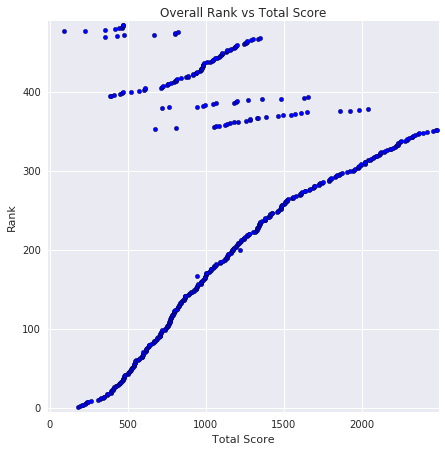

In [7]:
import matplotlib.pyplot as mp
%matplotlib inline

# Plot raw data
def plot_overall(tfx):
  mp.figure(figsize=(7, 7))
  mp.xlim([-10, max(tfx['Total Score']) + 10])
  mp.ylim([-5, max(tfx['Rank']) + 5])
  mp.title('Overall Rank vs Total Score')
  mp.xlabel('Total Score')
  mp.ylabel('Rank')
  mp.scatter(tfx['Total Score'], tfx['Rank'])
plot_overall(tfx)

At first glance, this resulting plot was not expected. A linear, positivly correlated relationship between score and rank was expected. Almost like what is exhibited for ranks between 1 to roughly 350. However, there are two problematic trends in the data:
* The outliers at the top of the figure have lower Total Scores, yet seem to be at arbitrarily low ranks (high values, which is unexpected).
* There are two data points that seem to be outside the otherwise linear trend in ranks under 350. One outlier is at rank 167 and the other is at 200.

The stratification of ranks and scores at the top of the figure is due to athletes not completing and entering scores for all the events. When assessing the overall Ranks for athletes, FloElite must first assess rankings based on scores from athletes that completed all events. Refer to the Completion Rule outlined above. This is the main part of the plot for ranks between 1 and ~350. Next, FloElite must assess rankings based on scores from athletes that completed all but one event, then ranked athletes that completed all but two events and so on. In the plot, you can see roughly the stratification of at the top of the figure exhibits five linear trends. Therefore, the unexpected trend at the top of the plot can be explained.

The other two outliers within rank 1 to ~350 are problematic and no explanation readily presents itself. The overall Rank is determined by Total Score and the Total Score is a function of the individual event rankings. Thus, analysis in the individual event score and rank relationships is next.

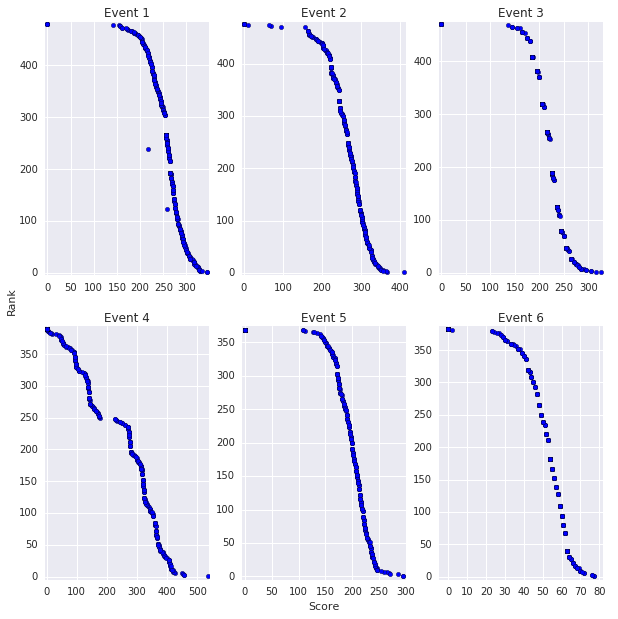

In [8]:
# Plot the rank-score for each event
def plot_events(tfx):
  f = mp.figure(figsize=(10, 10))
  ax = f.add_subplot(111)
  ax.set_xlabel('Score')
  ax.set_ylabel('Rank')
  ax.set_axis_bgcolor('white')
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
  for e in range(1, 7):
      col_rank = 'Q'+str(e)+'R'
      col_scor = 'Q'+str(e)+'S'
      col_v = 'Q'+str(e)+'RV'
      axs = f.add_subplot(2, 3, e)
      axs.scatter(tfx[col_scor], tfx[col_rank])
      axs.set_xlim([-5, max(tfx[col_scor])+5])
      axs.set_ylim([-5, max(tfx[col_rank])+5])
      axs.set_title('Event '+str(e))
plot_events(tfx)

Each event has an expected overall trend. Each event is an AMRAP style or max lift workout. So a high score gives a high rank (low numerical value), and each figure has a negative correlation. Some events exhibit tails at the top and bottom of the pack, which showcases how strong/weak certain individuals are in each event, respectively. You can even see the weight groupings in Event 3 as people maxed out on weights at 200 lbs, 215 lbs, 225 lbs, etc.

However, at first glance, Event 1 showed two clear outliers. Both data points had lower scores, but higher ranks than comparable athletes in the plot. The two problem ranks are 124 and 239. Looking at the first outlier on the FloElite leaderboard reveals an irregularity:

![](andrew_monrial.png "")

So, for Event 1, Andrew Monrial has a score of 259 and is ranked 124th. The plot shows other athletes with a score of 259 received a much lower rank, and so does the FloElite leaderboard, which is the source of the data:

![](eric_tejada.png "")

Eric Tejada entered the same exact score as Andrew Monrial for Event 1, but received a much lower (higher numerical value) rank for the event. What happened here? Double checking the other obvious outlier lead to the same issue: *There are unexplainable irregularities in the individual event and overall rankings...*

## New Question
I set out with a question about sizing up my competition, but now I am concerned with the validity of the FloElite results. The two outliers identified above were obvious, but are there other issues with the data that the plots are not able to demonstrate? Thus, I set out with a new question: 

"Did all the qualifing athletes correctly recieve a qualifying spot?"

The TFX Online Qualifier competition allows everyone the chance to compete for a spot at the TFX competition in January. Spots are limited, so the qualifier provides a means for selecting the athletes. If the rankings of these athletes does not meet the rules and expectations of the competition, then were certain athletes missed and did not receive invitations?

## Re-ranking the Results
To verify the results, the following analysis 
* Recomputes the rankings of the individual events
* Recomputes the athletes' Total Score
* Re-ranks the overall competition rankings

The scores athlete's entered for the individual events never change and still come directly from the scraping of the FloElite leaderboard. The assumption here is that all scores are entered into the FloElite website correctly, and blank scores can be correctly represented with zeroes.

First, re-rank the individual events:

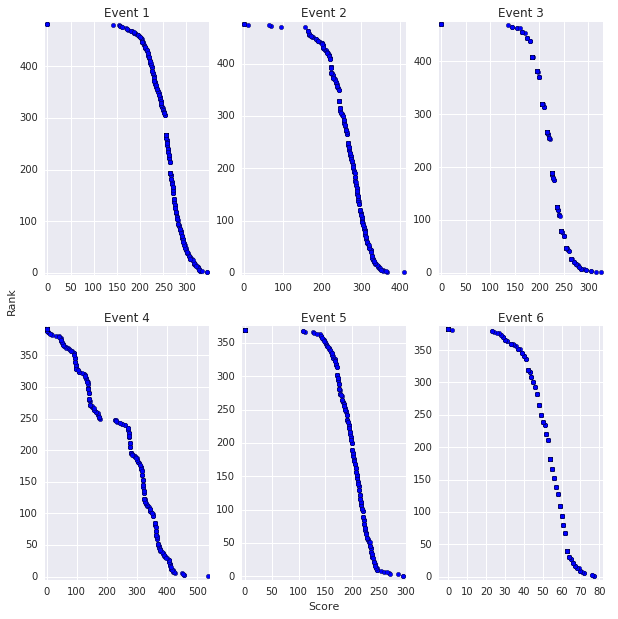

In [9]:
# Preserve Original
tfx_u = tfx.copy(deep=True)

# Re-Rank each Event
def rerank_events(tfx_u):
  for e in range(1, 7):
      col_rank = 'Q'+str(e)+'R'
      col_scor = 'Q'+str(e)+'S'
      tfx_u.sort_values(col_scor, ascending=False, inplace=True) # Max score is highest rank for each event
      tfx_u.reset_index(inplace=True)
      tfx_u.loc[:, col_rank] = tfx_u[col_scor].rank(ascending=False, method='min')
      tfx_u.set_index('Athlete', inplace=True)
  return tfx_u
tfx_u = rerank_events(tfx_u)
plot_events(tfx_u)

With the new re-ranking, the trends in each event are comparable to the original, but the two outliers in Event 1 are no longer there. In fact, Andrew Monrial's rank now for Event 1 is shared with Eric Tejada as expected.

In [10]:
tfx_u.loc["Andrew Monrial"]["Q1R"]

247.0

Next, re-ranking the overall results, but the Total Score must be recomputed first. In order to take into account the Completion Rule, anyone with a zero score for any of the events receives the highest total score plus one. Thus, when the athletes are re-ranked based on their score, they will receive last place overall. This is a simplifying assumption for this analysis, and is unlike what FloElite did in the assessment of overall Ranks in the leaderboard.

,Rank,Q1R,Q1S,Q2R,Q2S,Q3R,Q3S,Q4R,Q4S,Q5R,Q5S,Q6R,Q6S,Total Score,Gym
Athlete,,,,,,,,,,,,,,,
Jonathan Vanover,1.0,4.0,330.0,24.0,331.0,7.0,291.0,113.0,334.0,5.0,268.0,30.0,64.0,183.0,House of Power
Zentez Eleby,2.0,72.0,290.0,33.0,327.0,27.0,265.0,52.0,369.0,12.0,245.0,1.0,77.0,197.0,Sherman powerfit
Jean Banos,3.0,1.0,344.0,41.0,325.0,16.0,275.0,123.0,324.0,19.0,242.0,8.0,70.0,208.0,Warhouse Strength & Conditioning
Scott Church,4.0,4.0,330.0,5.0,356.0,27.0,265.0,72.0,363.0,36.0,235.0,68.0,62.0,212.0,Garage Gym
Brandon Head,5.0,17.0,318.0,27.0,329.0,27.0,265.0,133.0,323.0,22.0,240.0,1.0,77.0,227.0,Grapevine CrossFit


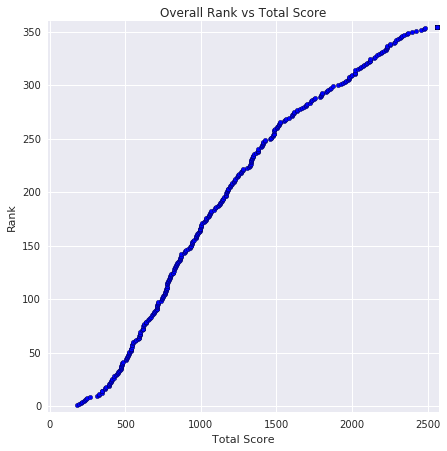

In [11]:
rank_cols = ['Q1R', 'Q2R', 'Q3R', 'Q4R', 'Q5R', 'Q6R']
scor_cols = ['Q1S', 'Q2S', 'Q3S', 'Q4S', 'Q5S', 'Q6S']
verf_cols = ['Q1RV', 'Q2RV', 'Q3RV', 'Q4RV', 'Q5RV', 'Q6RV']

# Re-rank Overall
def rerank_overall(tfx_u, apply_rules=True):
  tfx_u.loc[:, "Total Score"] = tfx_u[rank_cols].sum(axis=1) # Recalculates total score based on new ranking
  # If anyone has a zero score, for any event, give them last place overall
  if apply_rules:
      max_ts = max(tfx_u["Total Score"])
      #print(max_ts)
      tfx_u.loc[:, "Total Score"] = tfx_u.apply(lambda r: max_ts+1 if (r == 0).any() else r["Total Score"], axis=1)
  tfx_u.sort_values("Total Score", inplace=True) # Min score is highest rank
  #tfx_u.reset_index(inplace=True)
  tfx_u.loc[:, 'Rank'] = tfx_u['Total Score'].rank(method='min')
  #tfx_u.set_index('Athlete', inplace=True)
  tfx_u.sort_values("Rank", inplace=True)
  return tfx_u
tfx_u = rerank_overall(tfx_u)
plot_overall(tfx_u)
tfx_u.head()

Re-ranking the data provides a linear, positive correlation on Total Score to overall Rank, which was initially expect in the data directly scraped from the FloElite leaderboard. In this analysis, the stratification seen in the original set of data is collapsed to a single point, which is last place. There is no rank discrimination for athletes that completed a subset of the individual events.

The data generated from this analysis now follows the rules and expectations outlined for the TFX competition. A direct comparison of the original data scraped from the FloElite website with the data generated by this analysis shows the results are not the same.

In [12]:
print("Are all the ranks and scores the same? {}".format(tfx.equals(tfx_u)))

Are all the ranks and scores the same? False


Next, is to make a series of comparisons to answer the question of whether the qualifing athletes correctly received a qualifying spot.

## Verification
A comparison of the results are not the same, but does it matter? Did all qualifying athletes correctly receive a qualifying spot? Maybe a handful of ranks or scores are different, yet the differences are relative and the athletes that should have qualified still did qualify. 

In [13]:
def verify_ranks(tfx, tfx_u, division):
  # Order the two frames athletes to be the exact same
  tfx_u = tfx_u.reindex(tfx.index)

  # Validate Ranks
  tfx_u.reset_index(inplace=True)
  tfx.reset_index(inplace=True)
  for e in range(1, 7):
      col_rank = 'Q'+str(e)+'R'
      col_new = 'Q'+str(e)+'RV'
      tfx[col_new] = np.where(tfx_u[col_rank] == tfx[col_rank], True, False)
  tfx['RankV'] = np.where(tfx_u['Rank'] == tfx['Rank'], True, False)
  tfx_u.set_index('Athlete', inplace=True)
  tfx.set_index('Athlete', inplace=True)
  #print(tfx.head())

  # Qualifying Athletes
  tfx.sort_values("Rank", inplace=True)
  tfx_u.sort_values("Rank", inplace=True)
  tfx.reset_index(inplace=True)
  tfx_u.reset_index(inplace=True)
  tfx_q = tfx.iloc[:dmap[division]["n_qualified"]].copy(deep=True)
  tfx_uq = tfx_u.iloc[:dmap[division]["n_qualified"]].copy(deep=True)
  tfx_uq.set_index('Athlete', inplace=True)
  tfx_q.set_index('Athlete', inplace=True)
  tfx_u.set_index('Athlete', inplace=True)
  tfx.set_index('Athlete', inplace=True)
  #print(tfx_q[['Total Score', 'Rank', 'RankV']])
  #print(tfx_uq[['Total Score', 'Rank']])
  tfx_uq.sort_index(inplace=True)
  tfx_q.sort_index(inplace=True)
  #print(tfx_q.index)
  #print(tfx_uq.index)
  deserving = np.all(tfx_q.index == tfx_uq.index)
  print("Did all qualifying athletes correctly receive a qualifying spot? {}\n"\
          .format(deserving))
  ath_q_des = [i for i in tfx_uq.index if i not in tfx_q.index]
  ath_q_undes = [i for i in tfx_q.index if i not in tfx_uq.index]
  if not deserving:
      print("Athletes ranked outside the qualifier cut-off, but actually qualified:")
      print(ath_q_des)
      print('')
      print("Athletes ranked within the qualifier cut-off, but didn't actually qualified:")
      print(ath_q_undes)
      print('')
  return tfx, tfx_u, tfx_q, tfx_uq
tfx, tfx_u, tfx_q, tfx_uq = verify_ranks(tfx, tfx_u, "ISM")

Did all qualifying athletes correctly receive a qualifying spot? True



For the Intermediate/Scaled Men's division, all the athletes who were suppose to qualify did qualify, despite the inconsistencies seen in the rankings. Next, were any of the qualifiying athletes ranks computed differently in this analysis as compared to the results from the FloElite leaderboard?

In [14]:
def correct_ranks(tfx, tfx_u, tfx_q, tfx_uq):
  # Determine Correct Ranks for all
  tfx_u = tfx_u.reindex(tfx.index)
  tfx_v = tfx_u[tfx['RankV'] == False].copy(deep=True)
  tfx_ve = []
  for e in range(1, 7):
      col_v = 'Q'+str(e)+'RV'
      tfx_ve.append(tfx_u[tfx[col_v] == False])

  # Determine Correct Ranks for qualifying athletes
  #print(tfx_uq)
  ath_qm = tfx_uq.merge(tfx_q, how='outer', left_index=True, right_index=True).index
  #print(ath_qm)
  tfx_vq = tfx_u.loc[ath_qm].copy(deep=True)
  tfx_wq = tfx.loc[ath_qm].copy(deep=True)
  tfx_vq = tfx_vq[tfx_wq['RankV'] == False]
  tfx_wq = tfx_wq[tfx_wq['RankV'] == False]
  tfx_wq.sort_values('Rank', inplace=True)

  #print(tfx_vq.loc['Adam Vinson'])
  #print(tfx_wq.loc['Adam Vinson'])
  # Print athletes with incorrect ranks
  print("Qualifying athletes with rank discrepancies:")
  print("{:<25}{:<15}{:15}".format("Athlete", "FloElite Rank", "Recomputed Rank"))
  for a, cols in tfx_wq.iterrows():
      print("{:<25}{:<15}{:<15}".format(a, int(cols['Rank']), int(tfx_vq.loc[a]['Rank'])))
  return tfx, tfx_u, tfx_q, tfx_uq, tfx_v, tfx_ve, tfx_vq, tfx_wq
tfx, tfx_u, tfx_q, tfx_uq, tfx_v, tfx_ve, tfx_vq, tfx_wq = correct_ranks(tfx, tfx_u, tfx_q, tfx_uq)

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank
Tyler Mudd               46             47             
Bruce Moore              73             72             
Derrick Grant            73             72             
John McMahon             110            111            
Jake Floyd               112            111            


It looks like a handful of ranks are different in this analysis, but only by about one place. This is likely due to the outliers exhibited in Event 1. In addition, the cutoff between the Intermediate and Scaled divisions is at 85th place. There is no rank displacement around this cut-off either, which is good. It means that the athletes that qualify for the Intermediate division correctly received a spot for that division and similarly with the Scaled division. 

To visually see how many of the other ranks are different compared to the original FloElite data, the original rank-score relationship is plotted, but if the original rank does not match the rank computed by this analysis it is colored red.

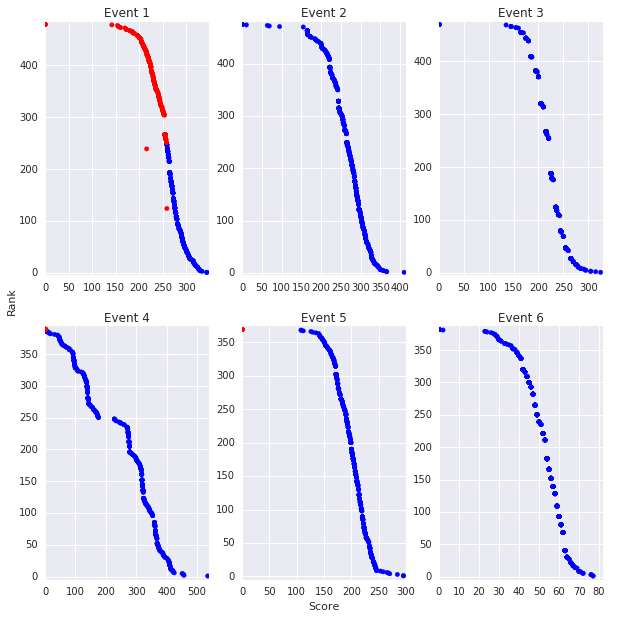

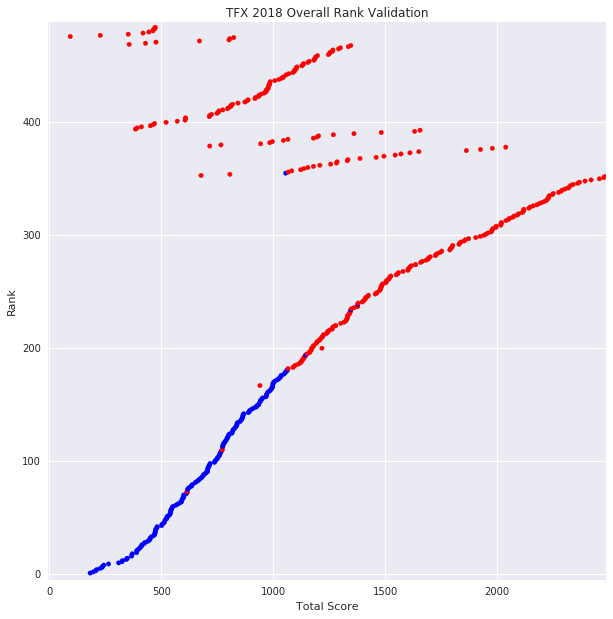

In [15]:
def plot_rank_verification(tfx, tfx_v, tfx_ve):
  # Plot Rank Validation
  cmap = {True: 'b', False: 'r'}
  f = mp.figure(figsize=(10, 10))
  ax = f.add_subplot(111)
  ax.set_xlabel('Score')
  ax.set_ylabel('Rank')
  ax.set_axis_bgcolor('white')
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
  for e in range(1, 7):
      col_rank = 'Q'+str(e)+'R'
      col_scor = 'Q'+str(e)+'S'
      col_v = 'Q'+str(e)+'RV'
      axs = f.add_subplot(2, 3, e)
      axs.scatter(tfx[col_scor], tfx[col_rank], marker='o', color=tfx[col_v].apply(lambda x: cmap[x]))#, facecolors='none')
      #axs.scatter(tfx_ve[e-1][col_scor], tfx_ve[e-1][col_rank], marker='x', color='g')
      axs.set_xlim([0, max(tfx[col_scor])+5])
      axs.set_ylim([-5, max(tfx[col_rank])+5])
      axs.set_title('Event '+str(e))
  mp.figure(figsize=(10, 10))
  mp.scatter(tfx['Total Score'], tfx['Rank'], marker='o', color=tfx['RankV'].apply(lambda x: cmap[x]))#, facecolors='none')
  #mp.scatter(tfx_v['Total Score'], tfx_v['Rank'], marker='x', color='g') # Mark
  mp.title('TFX 2018 Overall Rank Validation')
  mp.xlabel('Total Score')
  mp.ylabel('Rank')
  mp.xlim([-5, max(tfx['Total Score']) + 5])
  mp.ylim([-5, max(tfx['Rank']) + 5])
plot_rank_verification(tfx, tfx_v, tfx_ve)

Again, based on this analysis' re-ranking, the ranks of athletes are marked red if they do not match with the original data directly from the FloElite leaderboard. It appears that the way the ranks were assessed by FloElite, in Event 1, essentially lead to most of the issues with the overall rankings. Keep in mind, if one athlete's rank is off it has the potential to mess up all following ranks. 

### Conclusion for Intermediate/Scaled Men's Division
For the Intermediate/Scaled Men's division, many many athletes ranks are different, albeit a majority are only by one place. In addition, the athletes that did well enough to qualify did earn qualifying spots in their correct divisions. However, the same questions need to be applied to all the other divisions.

## Assessing All Divisons
Let's quickly assess all of the other divisions with the routines developed for looking at the Intermediate/Scaled Men's division.

In [16]:
# Create single function for verifying a divisions results.
def verify(division, plot_results=True, apply_rules=True):
  table = clean_raw(extract(division))
  tfx = table.copy(deep=True)
  tfx_u = tfx.copy(deep=True)
  tfx_u = rerank_events(tfx_u)
  tfx_u = rerank_overall(tfx_u, apply_rules)
  print("Are all the ranks and scores correct? {}\n".format(tfx.equals(tfx_u)))
  tfx, tfx_u, tfx_q, tfx_uq = verify_ranks(tfx, tfx_u, division)
  tfx, tfx_u, tfx_q, tfx_uq, tfx_v, tfx_ve, tfx_vq, tfx_wq = correct_ranks(tfx, tfx_u, tfx_q, tfx_uq)
  if plot_results:
    plot_rank_verification(tfx, tfx_v, tfx_ve) 
  return tfx, tfx_u

### Pro/Amateur Men Division
The Pro/Amateur divisions are competing for money, not only in the qualifier, but also for at TFX in January. Not qualifying could mean missing out in a opportunity for thousands of dollars. The implication being that it is critical to ensure the qualifying athletes correctly earned an invitation. Here, extract the data from the FloElite Pro/Amateur Men's leaderboard and apply the generic routines developed previously.

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank
Ricardo Cano             71             70             
Madison Townley          81             82             
Logan Bush               88             87             


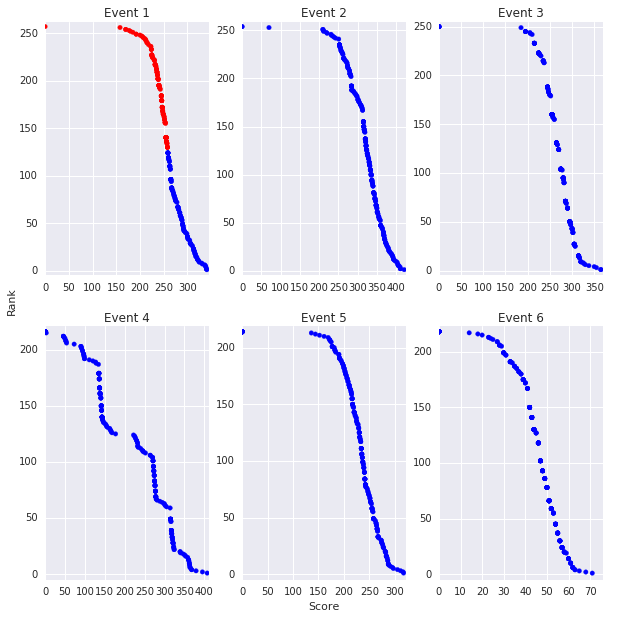

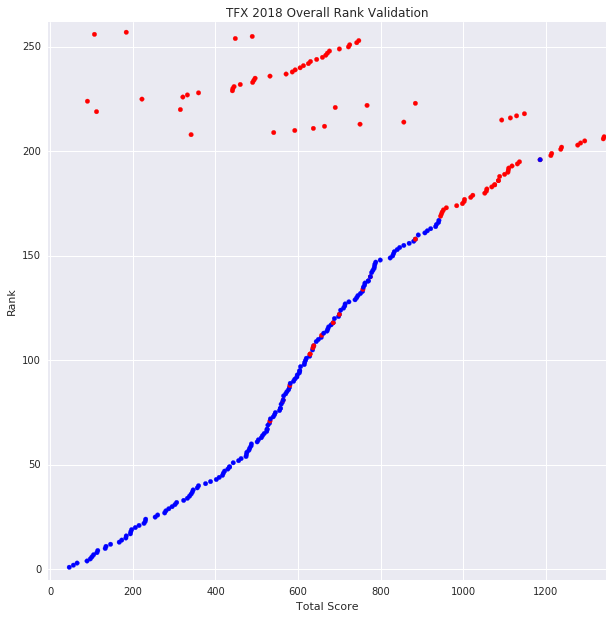

In [17]:
_ = verify("PAM")

Again, the qualifying athletes did correctly qualify for the respective Pro and Amateur divisions (cut-off at 30), but we still see a handful of athletes with different rankings.

#### Aside: Applying the Completion Rule
In all of the analyses, by default, the Completion Rule is applied such that each athlete must complete and enter a score for every individual event to be considered in the overall rankings, otherwise the athlete receives last place overall. The rule makes a lot of sense, but there are some interesting results in the Pro/Amature Men's division if you do not apply this rule. Consider:

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? False

Athletes ranked outside the qualifier cut-off, but actually qualified:
['Adam Vinson', 'Ricky Carrillo']

Athletes ranked within the qualifier cut-off, but didn't actually qualified:
['Jaime AcuÃ±a', 'Tyler Tomerlin']

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank
Ricardo Cano             71             70             
Kolton Porter            75             76             
Jonathan Duncan          76             77             
David Moore              77             79             
Evan Coachman            77             79             
Robert Hibbard           79             81             
Dillon Cartwright        80             82             
Bryce Carlson            81             83             
Madison Townley          81             84             
Aaron Williams    

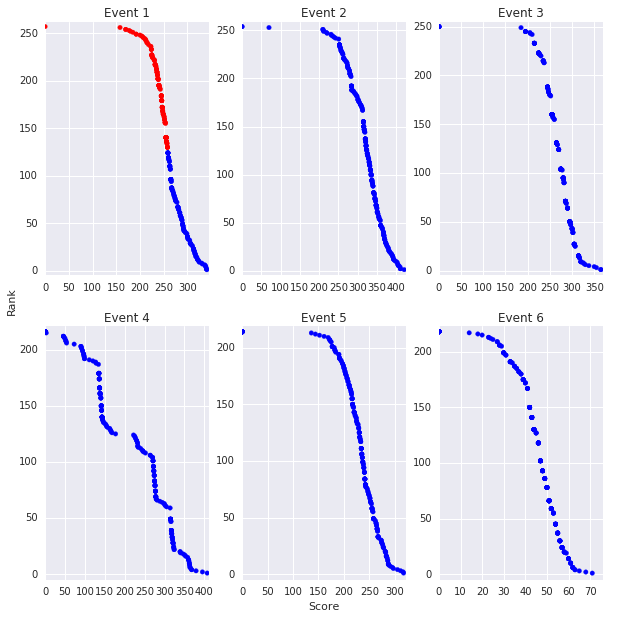

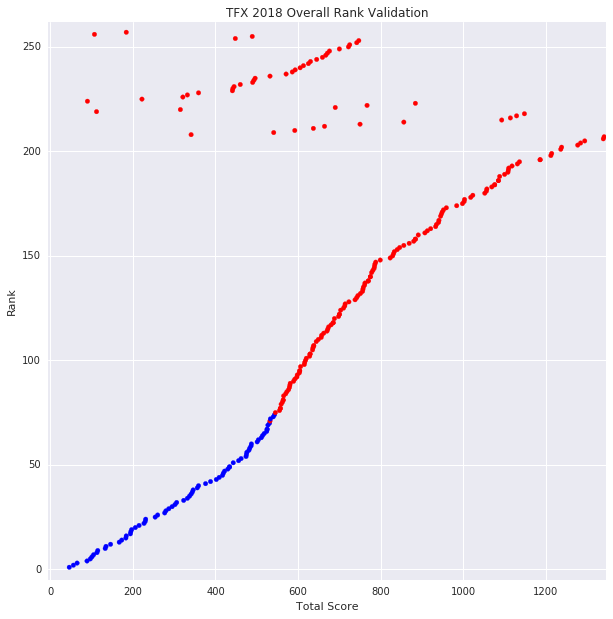

In [18]:
tfx_pam, tfx_pam_u = verify("PAM", True, False)

Looking at the details from this analysis, there are two athletes, Adam Vinson and Ricky Carrillo, that could have qualified, if they had just entered a last place score in the event's they had missed! Look at Adam's result from the FloElite leaderboard:

![](adam_vinson.png "")

He missed Events 4 and 5. For this analysis, the missing scores are represented by zeros and the athlete receives a last place ranking for those individual events. Adam missed two events, but if he had just done a single rep for each of the last two events and entered a score, he would have placed 75th overall! He did that well in the first four events! Take a look at the data computed by this analysis for Adam:

In [19]:
tfx_pam_u.loc['Adam Vinson'].T

Rank            75
Q1R             34
Q1S            301
Q2R             40
Q2S            367
Q3R              7
Q3S            327
Q4R             31
Q4S            320
Q5R            214
Q5S              0
Q6R            218
Q6S              0
Total Score    544
Gym            NaN
Name: Adam Vinson, dtype: object

Similarly with Ricky, if he had just entered a single rep for Event 5, he could have placed 77th.

![](ricky_carrillo.png "")

This pecularity did not happen in the Intermediate/Scaled Men's divison, and the other divisions were not extensively checked, but these results are very interesting. Furthermore, it begs the question on how to correctly handle the rankings for athletes that enter no scores. Should they essentially be disqualified from the overall rankings as Adam and Ricky have effectively been here? Or should they be given the benefit of the doubt, assigned last place for the individual event and ranked accordingly in the overall ranking?

### Pro/Amateur Women's Division
Next verifying the Pro/Amateur Women results:

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank
Chelsea Potter           19             18             
Mary Lou Womack          20             19             
Amanda Garces            21             20             
Vanessa McCoy            22             21             
Taylor Cooley            23             22             
Heather Gammel           24             23             
Andilauren Garcia        25             24             
Julie VanHoy             26             25             
Keelee Norris            27             26             
Kita Dicks               27             31             
Emily Graham             28             27             
Anabelle Canchola        29             28             
Lydia Novotny            30             29             
Heather Shuttl

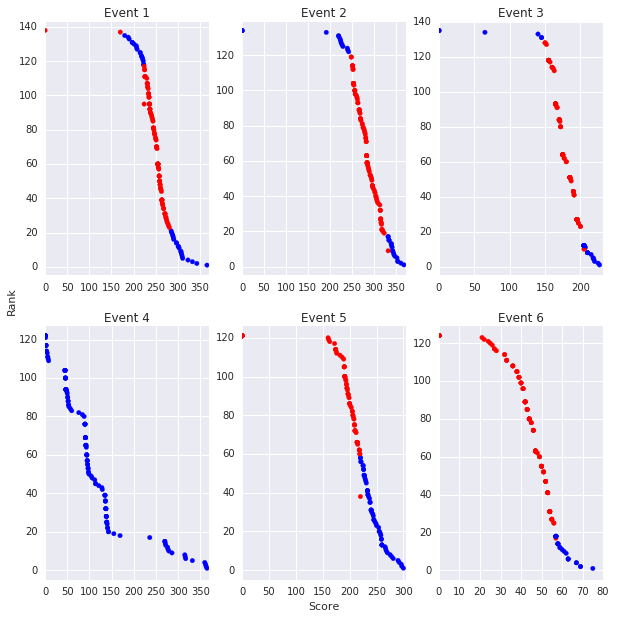

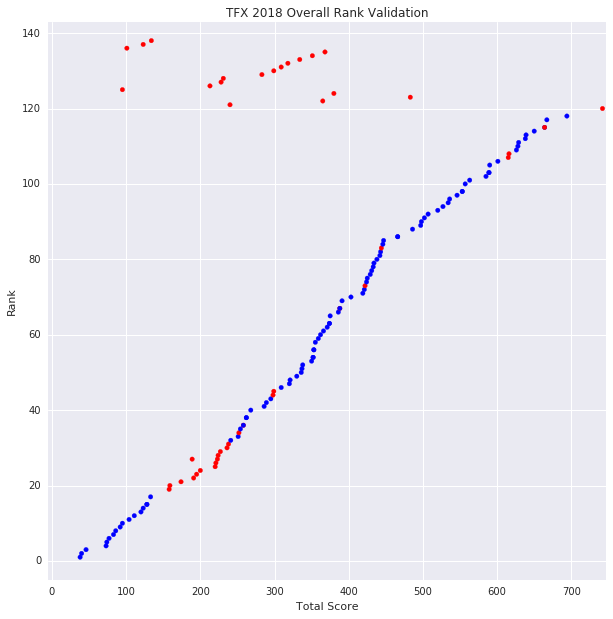

In [20]:
tfx_paw, tfx_paw_u = verify("PAW")

A lot more ranks are different for this women's division compared to the FloElite leaderboard. The men's divisons seemed to have the most issues in Event 1, but many more ranks are computed as different for most of the events in this division. 

More importantly, the cutoff between Pro and Amateur is at 20th place and Amanda Garces is ranked 21st on the FloElite leaderboard. However, this analysis puts her at 20th place. Thus, this analysis indicates she could have qualified for the Pro division. It has been easy to take this analysis for granted thus far, because all the qualifying athletes correctly received qualifying spots, until now. 

To determine what happened with respect to Amanda Garces' overall Rank, further assessment into the differences in the individual events is needed. Consider:

In [21]:
tfx_paw.loc["Amanda Garces"][verf_cols]

Q1RV    False
Q2RV    False
Q3RV    False
Q4RV     True
Q5RV     True
Q6RV     True
Name: Amanda Garces, dtype: object

The analysis indicates that her ranks in the first three individual events are different than the FloElite leaderboard, but why? Printing the first 25 ranks for Event 1, and their respective scores from the FloElite data uncovers a subtle issue:

In [22]:
tfx_paw_e1 = tfx_paw[['Q1R', 'Q1S']].sort_values('Q1S', ascending=False)
tfx_paw_e1.iloc[:24]

,Q1R,Q1S
Athlete,,
Lydia Novotny,1.0,366.0
Marisa De los Santos,2.0,343.0
Natalie Newhart,3.0,333.0
Chely Galvan,4.0,323.0
April Bullock,5.0,311.0
Brandi Yates,6.0,310.0
Andee Keefe,7.0,309.0
Stephany Osorto,8.0,308.0
Allison Ralfs,9.0,307.0


In the FloElite leaderboard data, there is no 22nd place. Ranks are only skipped if more than one athlete has the same score, and this is not the case here. It does happen for 14th place, and the data above correctly skips 15th place because the scores for Amber Carrillo and Leah Irons are the same. However, for 22nd place there is no explanation: Courtney Walker is ranked 21st with 285 points, but then Heather Gammel is ranked 23rd with 281 points and then Holly Henderson is at 24th with 279. There are no duplicate scores, yet 22nd place is skipped. This causes Amanda Garces rank for Event 1 to be 25th instead of 24th. The FloElite leaderboard website does not have the function to sort individual events, but purusing the leaderboard will show that there is no 22nd place where there should be.

The FloElite leaderboard exhibits a different issue for Event 2. Printing the first 21st ranks and their respective scores from the FloElite data:

In [23]:
tfx_paw_e2 = tfx_paw[['Q2R', 'Q2S']].sort_values('Q2S', ascending=False)
tfx_paw_e2.iloc[:22]

,Q2R,Q2S
Athlete,,
Alexis Johnson,1.0,369.0
Natalie Newhart,2.0,362.0
Brooke Haas,3.0,355.0
Leah Irons,3.0,355.0
Chely Galvan,5.0,353.0
Hollye Henderson,6.0,348.0
Amber Carrillo,7.0,346.0
Lydia Novotny,8.0,345.0
Courtney Walker,9.0,343.0


There is a clear outlier in the original Event 2 data: Kita Dicks received a rank of 9th but only had a score of 333. Rachel Garibay and Courtney Walker both also received 9th, but they had scores of 343. This is fairly easy to double check on the leaderboard.

![](rachel_garibay.png "")

Compared to:

![](kita_dicks.png "")

In this analysis, it causes Amanda Garces rank to change from 21st to 22nd. Last, consider Event 3. Printing the first 32 ranks and their respective scores from the FloElite data shows a similar issue as from Event 2.

In [24]:
tfx_paw_e3 = tfx_paw[['Q3R', 'Q3S']].sort_values('Q3S', ascending=False)
tfx_paw_e3.iloc[:32]

,Q3R,Q3S
Athlete,,
Laura Calicutt,1.0,227.0
Rachel Garibay,2.0,225.0
Claire Garcia,3.0,220.0
Brooke Haas,4.0,219.0
Stephany Osorto,5.0,218.0
Shannon Kaylor,5.0,218.0
Jessica Shaw,7.0,215.0
Heather Sanchez,8.0,210.0
Allison Ralfs,8.0,210.0


Again, Kita Dicks was ranked 10th, when she should have been 12th. This caused Amanda Garces rank to go from 27th to 28th. 

Now, an athlete's Total Score is the sum of their individual event ranks, and Amanda's net difference after reevalutating these three events is +1 points. So, it may seem unintuitive that, although her total points went up, her overall rank went up too (lower numerical value), but, remember, one incorrect rank has the potential to cause many athletes' ranks to be incorrect. Thus, many athletes scores went up due to this issue with Kita Dicks rankings in two events. This is showcased in the plots above. 

In conclusion, this analysis indicates Amanda Garces could have received a qualifying spot for the Women's Pro division at TFX in January, but may not have based on the FloElite leaderboard data.

### Intermediate/Scaled Women's Division
For the Intermediate/Scaled Women division, the cutoff between Intermediate and Scaled divisions is at 60th place. The FloElite leaderboard has Crystal Cadena at 60th place, but this analysis ranks Crystal at 62nd place. However, it did not displace someone else who also qualified for the Intermediate division.

In [25]:
_ = verify("ISW", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank
Kirby Leipsic            46             45             
Crystal Turi             50             49             
Lexy Diaz                53             54             
Jordan Schilling         58             59             
Krissy Lucas             59             58             
Crystal Cadena           60             62             
Edna Martinez            64             63             
Amanda Henry             77             78             
Lillian Macias           79             78             
Kelley Lensing           83             82             
Amanda Chappell          89             88             
Carla Noel               89             90             
Heather Hofstetter       91             90             
Ashley Garrett

### Masters 35-39 Men Division
The first division that has no rank differences with the qualifying athletes.

In [26]:
_ = verify("M35M", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


### Masters 35-39 Women Division
Assessing the Masters 35-39 Womon's division.

In [27]:
tfx_m35w, tfx_m35w_u = verify("M35W", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? False

Athletes ranked outside the qualifier cut-off, but actually qualified:
['Raquel Waddles']

Athletes ranked within the qualifier cut-off, but didn't actually qualified:
['Chasmi Stewart']

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank
Chasmi Stewart           20             25             
Raquel Waddles           22             20             


This division actually has a pecularity in the data, which made it looked like Raquel Waddles should have qualified, but didn't. Chasmi Stewart entered a zero score for Event 4. She did not leave it blank, she actually entered a zero score. Thus, the issues has to do with the assumptions about applying the Completiton Rule.  When the data is scraped from the web, blank entries are filled with zero scores. Then in this analysis, when computing Total Score, the Completion Rule is applied. If an athlete has a zero score for any event, they last overall and this is what happened to Chasmi Stewart, here. FloElite must make a distinction between blank or no-scores and zero scores in their analysis.

If the Completion Rule is not applied and a zero score is considered to be a valid score, then all is well in this division.

In [28]:
tfx_m35w, tfx_m35w_u = verify("M35W", False, False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


Thus, an important question is whether a zero score is considered a valid score as oppose to no score? Did an athlete "complete" an event if they did not complete any reps or lift any weight? The implications are important as seen in ranking athletes in the Pro/Amateur Men's division.

### Masters 40-44 Men/Women Division
Both of these division correctly qualified the athletes.

In [29]:
_ = verify("M40M", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


In [30]:
_ = verify("M40W", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


### Masters 45-49 Men/Women's Division
Both of these division correctly qualified the athletes, although a few ranks are different in the women's division.

In [31]:
_ = verify("M45M", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


In [32]:
_ = verify("M45W", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank
Rebecca Cates            6              5              
Robin Sproba             6              5              
Angela Simmons           8              7              
Kimberley Drobny         9              8              
Susan Norris             10             9              
Tara Huntress            11             10             


### Masters 50+ Men/Women's Division
Both of these division correctly qualified the athletes!

In [33]:
_ = verify("M50W", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


In [34]:
_ = verify("M50W", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


### Teen Division
All the teen divisions check out too!

In [35]:
_ = verify("T14M", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


In [36]:
_ = verify("T14W", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


In [37]:
_ = verify("T16M", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


In [38]:
_ = verify("T16W", False)

Extracting data from the leaderboard...

Are all the ranks and scores correct? False

Did all qualifying athletes correctly receive a qualifying spot? True

Qualifying athletes with rank discrepancies:
Athlete                  FloElite Rank  Recomputed Rank


### Team Division
The Team division has an extra layer that the HTML parser is unable to scrap from the web as is. So, there are no results for the Team division.

## Conclusion
The analysis showcases irregularities in the results for the 2018 The Fittest Experience (TFX) Online Qualifier held in October 2017. The leaderboard results are hosted and assessed by a third-part company, FloElite. 

The details in this analysis showcase that a large percentage of athlete's ranks are not consistent within the expectations and rules of the TFX competition. The most significant finding is for the Women's Pro/Amature Division, where Amanda Garces may have been excluded from the Women's Pro Division due to inconsistencies in the rankings of other athletes in Events 1, 2 and 3. The Men's Pro/Amateur, the Intermediate/Scaled Men and Women, the Masters 35-39 Women and the Masters 45-49 Women's divisons all have rank irregularities in the qualifying spots, but the athletes in each of the divisions still correctly received qualifying spots. 

Furthermore, two special cases, the Pro/Amateur Men's division and the Masters 35-39 Women's division, demonstrate how different accounting of blank entries or zero scores could significantly change the outcome of the competition. Questions about the validity of a zero score for an individual event verses a blank entry or no-score needs to be considered to ensure athletes are correctly qualified. 

The hope is for this analysis to demonstrate the need for oversight and verification of the competition results. I call to action both [TFX](https://www.thefittestexperience.com/) and [FloElite](https://www.floelite.com/) to review these findings and assess internal processes to provide confidence and integrity in the results for the TFX competition in January.

In [39]:
!jupyter nbconvert TFX\ 2018\ Qualifiers\ Validation.ipynb --to html

[NbConvertApp] Converting notebook TFX 2018 Qualifiers Validation.ipynb to html
[NbConvertApp] Writing 1006539 bytes to TFX 2018 Qualifiers Validation.html
